In [7]:
# Core libraries
import os
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm  # Progress bars - makes training easier to watch!

# PyTorch - the deep learning framework we'll use
import torch
import torch.nn as nn  # Neural network building blocks
import torch.nn.functional as F  # Activation functions, etc.
from torch.utils.data import DataLoader, Dataset  # For handling data

# For working with medical imaging (.nii.gz files)
import nibabel as nib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split

# Ignore warnings to keep output clean
# import warnings
# warnings.filterwarnings('ignore')

# Set device - this tells PyTorch where to run computations
device = torch.device("cuda:0")  # Use 

In [8]:
# Set random seeds so results are reproducible
def set_seed(seed=42):
    """
    Setting seeds ensures you get the same results every time you run the code.
    This is important for debugging and comparing experiments!
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(42)
print("✅ Random seeds set")

✅ Random seeds set


In [9]:
import sys
sys.path.append("../")
import utils.hpc

DATA_DIR = utils.hpc.load_dataset_into_ram() if utils.hpc.running_on_hpc() else "/home/a3j/school/dl/project/3d/data/partial/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

print(f'Running on {"hpc" if utils.hpc.running_on_hpc() else "personal computer"}')
print(f'Using {"full dataset" if utils.hpc.running_on_hpc() else "partial dataset (10 patients)"}')
print(f'path: {DATA_DIR}')

Running on hpc
Using full dataset
path: /dev/shm/brats_data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData


In [10]:
# Check if directory exists
if os.path.exists(DATA_DIR):
    print(f"✅ Data directory found: {DATA_DIR}")
else:
    print(f"❌ Data directory NOT found: {DATA_DIR}")
    print("Please check your path!")

# Get list of patient folders
patient_folders = sorted([d for d in os.listdir(DATA_DIR) 
                         if os.path.isdir(os.path.join(DATA_DIR, d))])

print(f"\n📊 Total patients: {len(patient_folders)}")
print(f"First 5 patients: {patient_folders[:5]}")
print(f"Last 5 patients: {patient_folders[-5:]}")

# Check one patient's files
if len(patient_folders) > 0:
    sample_patient = patient_folders[0]
    sample_path = os.path.join(DATA_DIR, sample_patient)
    files = sorted(os.listdir(sample_path))
    print(f"\n📁 Files in {sample_patient}:")
    for f in files:
        print(f"  - {f}")

✅ Data directory found: /dev/shm/brats_data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData

📊 Total patients: 369
First 5 patients: ['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005']
Last 5 patients: ['BraTS20_Training_365', 'BraTS20_Training_366', 'BraTS20_Training_367', 'BraTS20_Training_368', 'BraTS20_Training_369']

📁 Files in BraTS20_Training_001:
  - BraTS20_Training_001_flair.nii
  - BraTS20_Training_001_seg.nii
  - BraTS20_Training_001_t1.nii
  - BraTS20_Training_001_t1ce.nii
  - BraTS20_Training_001_t2.nii


📌 Loading: BraTS20_Training_001

✅ Shape of each modality: (240, 240, 155)
✅ Shape of segmentation:  (240, 240, 155)
✅ Unique labels: [0. 1. 2. 4.]
   (0=Background, 1=Necrotic, 2=Edema, 4=Enhancing)



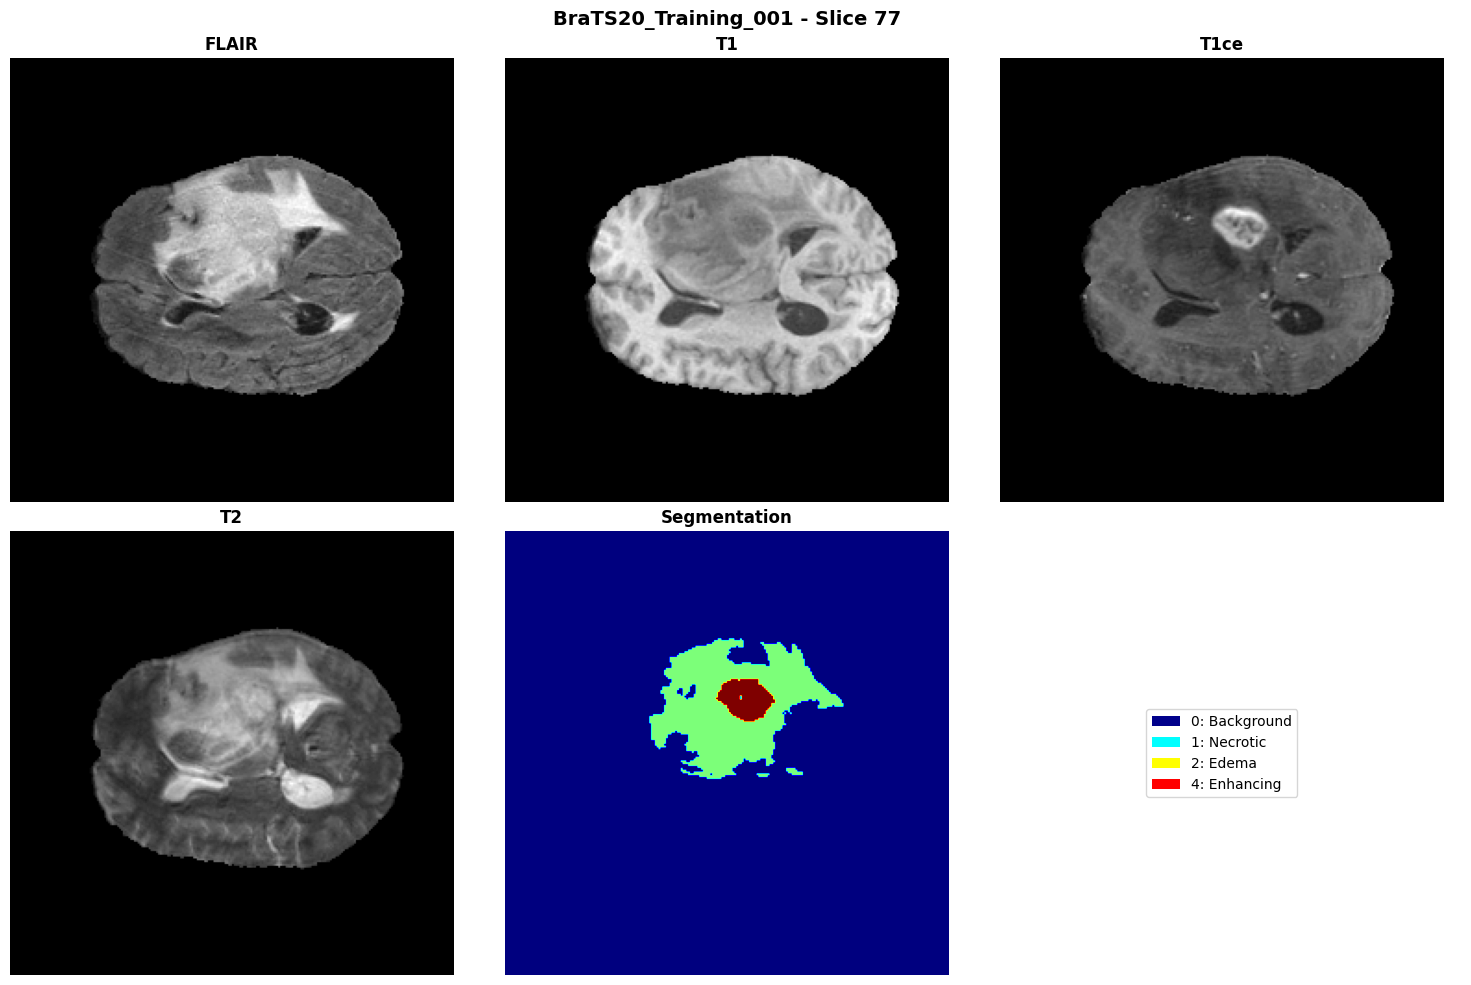


📊 SLICE ANALYSIS for BraTS20_Training_001:
   Total slices:          155
   Slices WITH tumor:     83 (53.5%)
   Slices WITHOUT tumor:  72 (46.5%)
   Tumor region:          Slices 30 to 112

📊 CLASS DISTRIBUTION for BraTS20_Training_001:
   Class                Pixels          Percentage
   --------------------------------------------------
   0 (Background     )    8,716,021    97.63%
   1 (Necrotic       )       15,443     0.17%
   2 (Edema          )      168,794     1.89%
   4 (Enhancing      )       27,742     0.31%

⚠️  IMBALANCE DETECTED:
   → Background dominates (~98%)
   → We MUST use weighted/combined loss function!

🔄 Analyzing all 369 patients...


Processing: 100%|██████████| 369/369 [00:44<00:00,  8.37it/s]


📊 DATASET-WIDE STATISTICS (369 patients):
   ────────────────────────────────────────────────────────────
   Total slices:                  57,195
   Slices WITH tumor:             24,422  ( 42.7%)
   Slices WITHOUT tumor:          32,773  ( 57.3%)

   Overall Class Distribution:
   ────────────────────────────────────────────────────────────
   Class 0 (Background     ):   3,257,699,276 pixels  (98.89%)
   Class 1 (Necrotic       ):       8,161,996 pixels  ( 0.25%)
   Class 2 (Edema          ):      21,302,318 pixels  ( 0.65%)
   Class 4 (Enhancing      ):       7,268,410 pixels  ( 0.22%)


In [12]:
# ============================================
# 1. LOAD ONE PATIENT (for visualization)
# ============================================

def load_patient_data(patient_folder):
    """
    Load all 4 MRI modalities + segmentation mask for one patient.
    
    Args:
        patient_folder: e.g., 'BraTS20_Training_001'
    
    Returns:
        modalities: dict with keys ['flair', 't1', 't1ce', 't2']
                   Each is a 3D numpy array (240, 240, 155)
        segmentation: 3D numpy array with labels {0, 1, 2, 4}
    """
    patient_path = os.path.join(DATA_DIR, patient_folder)
    
    # Load all 4 MRI scans into a dictionary
    modalities = {}
    for mod in ['flair', 't1', 't1ce', 't2']:
        file_path = os.path.join(patient_path, f"{patient_folder}_{mod}.nii")
        modalities[mod] = nib.load(file_path).get_fdata()  # Convert to numpy array
    
    # Load ground truth segmentation mask
    seg_path = os.path.join(patient_path, f"{patient_folder}_seg.nii")
    segmentation = nib.load(seg_path).get_fdata()
    
    return modalities, segmentation


# Load first patient as example
sample_patient = patient_folders[0]
print(f"📌 Loading: {sample_patient}\n")

modalities, segmentation = load_patient_data(sample_patient)

# Print basic info
print(f"✅ Shape of each modality: {modalities['flair'].shape}")
print(f"✅ Shape of segmentation:  {segmentation.shape}")
print(f"✅ Unique labels: {np.unique(segmentation)}")
print(f"   (0=Background, 1=Necrotic, 2=Edema, 4=Enhancing)\n")


# ============================================
# 2. VISUALIZE ONE SLICE (middle of brain)
# ============================================

# Extract middle slice where tumor is usually present
slice_idx = segmentation.shape[2] // 2  # Index 77 out of 155

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot all 4 modalities
axes[0, 0].imshow(modalities['flair'][:, :, slice_idx], cmap='gray')
axes[0, 0].set_title('FLAIR', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(modalities['t1'][:, :, slice_idx], cmap='gray')
axes[0, 1].set_title('T1', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(modalities['t1ce'][:, :, slice_idx], cmap='gray')
axes[0, 2].set_title('T1ce', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

axes[1, 0].imshow(modalities['t2'][:, :, slice_idx], cmap='gray')
axes[1, 0].set_title('T2', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# Plot segmentation with color-coded tumor regions
axes[1, 1].imshow(segmentation[:, :, slice_idx], cmap='jet', vmin=0, vmax=4)
axes[1, 1].set_title('Segmentation', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkblue', label='0: Background'),
    Patch(facecolor='cyan', label='1: Necrotic'),
    Patch(facecolor='yellow', label='2: Edema'),
    Patch(facecolor='red', label='4: Enhancing')
]
axes[1, 2].legend(handles=legend_elements, loc='center', fontsize=10)
axes[1, 2].axis('off')

plt.suptitle(f'{sample_patient} - Slice {slice_idx}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# ============================================
# 3. ANALYZE SLICE-LEVEL TUMOR DISTRIBUTION
# ============================================
# Purpose: Determine what % of slices contain tumor
# This tells us our actual dataset size for 2D U-Net

def count_tumor_slices(segmentation):
    """
    Count how many slices contain tumor pixels.
    
    Args:
        segmentation: 3D array (240, 240, 155)
    
    Returns:
        List of slice indices that contain any tumor (labels 1, 2, or 4)
    """
    tumor_slices = []
    
    # Loop through all 155 slices
    for i in range(segmentation.shape[2]):
        slice_2d = segmentation[:, :, i]
        
        # Check if slice has any tumor labels (1, 2, or 4)
        if np.any(np.isin(slice_2d, [1, 2, 4])):
            tumor_slices.append(i)
    
    return tumor_slices


# Analyze this patient
tumor_slices = count_tumor_slices(segmentation)

print(f"\n📊 SLICE ANALYSIS for {sample_patient}:")
print(f"   Total slices:          {segmentation.shape[2]}")
print(f"   Slices WITH tumor:     {len(tumor_slices)} ({len(tumor_slices)/155*100:.1f}%)")
print(f"   Slices WITHOUT tumor:  {155 - len(tumor_slices)} ({(155-len(tumor_slices))/155*100:.1f}%)")
print(f"   Tumor region:          Slices {min(tumor_slices)} to {max(tumor_slices)}")


# ============================================
# 4. ANALYZE CLASS IMBALANCE (CRITICAL!)
# ============================================
# Purpose: Understand pixel-level distribution
# This determines our LOSS FUNCTION choice!

def analyze_class_distribution(segmentation):
    """
    Calculate what % of pixels belong to each class.
    
    Returns:
        Dictionary with pixel counts and percentages per class
    """
    unique, counts = np.unique(segmentation, return_counts=True)
    total_pixels = segmentation.size
    
    # Build distribution dict
    dist = {}
    for label, count in zip(unique, counts):
        dist[int(label)] = {
            'count': int(count),
            'percentage': (count / total_pixels) * 100
        }
    
    return dist


# Analyze this patient
dist = analyze_class_distribution(segmentation)

print(f"\n📊 CLASS DISTRIBUTION for {sample_patient}:")
print(f"   {'Class':<20} {'Pixels':<15} {'Percentage'}")
print(f"   {'-'*50}")

class_names = {0: 'Background', 1: 'Necrotic', 2: 'Edema', 4: 'Enhancing'}
for label in [0, 1, 2, 4]:
    if label in dist:
        print(f"   {label} ({class_names[label]:<15}) "
              f"{dist[label]['count']:>12,}   {dist[label]['percentage']:>6.2f}%")

print(f"\n⚠️  IMBALANCE DETECTED:")
print(f"   → Background dominates (~{dist[0]['percentage']:.0f}%)")
print(f"   → We MUST use weighted/combined loss function!")


# ============================================
# 5. DATASET-WIDE STATISTICS
# ============================================
# Purpose: Aggregate statistics across all patients
# Tells us total training samples available

print(f"\n🔄 Analyzing all {len(patient_folders)} patients...")

# Initialize counters
total_slices = 0
total_tumor_slices = 0
class_counts = {0: 0, 1: 0, 2: 0, 4: 0}

# Loop through all patients with progress bar
for patient in tqdm(patient_folders, desc="Processing"):
    _, seg = load_patient_data(patient)
    
    # Count slices
    total_slices += seg.shape[2]
    tumor_slices_list = count_tumor_slices(seg)
    total_tumor_slices += len(tumor_slices_list)
    
    # Accumulate pixel counts per class
    unique, counts = np.unique(seg, return_counts=True)
    for label, count in zip(unique, counts):
        if int(label) in class_counts:
            class_counts[int(label)] += int(count)


# Print final statistics
print(f"\n📊 DATASET-WIDE STATISTICS ({len(patient_folders)} patients):")
print(f"   {'─'*60}")
print(f"   Total slices:              {total_slices:>10,}")
print(f"   Slices WITH tumor:         {total_tumor_slices:>10,}  ({total_tumor_slices/total_slices*100:>5.1f}%)")
print(f"   Slices WITHOUT tumor:      {total_slices-total_tumor_slices:>10,}  ({(total_slices-total_tumor_slices)/total_slices*100:>5.1f}%)")
print(f"\n   Overall Class Distribution:")
print(f"   {'─'*60}")

total_pixels = sum(class_counts.values())
for label in [0, 1, 2, 4]:
    count = class_counts[label]
    pct = (count / total_pixels) * 100
    print(f"   Class {label} ({class_names[label]:<15}): {count:>15,} pixels  ({pct:>5.2f}%)")

In [14]:
# ============================================================================
# BraTS 2020 PyTorch Dataset for 2D U-Net
# ============================================================================

import time

class BraTSDataset2D(Dataset):
    """
    PyTorch Dataset for BraTS 2020 Brain Tumor Segmentation (2D U-Net)
    
    Design Decisions:
    1. Filter empty slices: Only keep slices with tumor pixels (labels 1,2,4)
    2. Label remapping: {0,1,2,4} → {0,1,2,3} for PyTorch compatibility
    3. Normalization: Percentile clipping + Z-score on BRAIN REGION ONLY
    4. Input: 4-channel (T1, T1ce, T2, FLAIR) × 240×240 full slices
    5. Patient-level split: Prevent data leakage
    
    Args:
        patient_folders (list): List of patient folder names (e.g., ['BraTS20_Training_001'])
        data_root (str/Path): Path to BraTS data directory containing patient folders
        filter_empty (bool): If True, exclude slices with only background (default: True)
        transform (callable, optional): Data augmentation transform
    """
    
    def __init__(self, 
                 patient_folders,
                 data_root,
                 filter_empty=True,
                 transform=None):
        
        self.patient_folders = patient_folders
        self.data_root = Path(data_root)
        self.filter_empty = filter_empty
        self.transform = transform
        
        # MRI modality suffixes (BraTS naming convention)
        self.modalities = ['t1', 't1ce', 't2', 'flair']
        
        # Build index of all valid (patient, slice) pairs
        self.slice_index = self._build_slice_index()
        
        print(f"✅ Dataset initialized:")
        print(f"   - {len(self.slice_index)} slices from {len(patient_folders)} patients")
        if filter_empty:
            print(f"   - Empty slices filtered (tumor slices only)")
    
    def _build_slice_index(self):
        """
        Build index of all valid (patient_idx, slice_idx) pairs.
        
        If filter_empty=True:
            Only include slices with tumor pixels (labels in {1,2,4})
        
        Returns:
            list: [(patient_idx, slice_idx), ...]
        """
        slice_index = []
        
        for patient_idx, patient_folder in enumerate(self.patient_folders):
            patient_path = self.data_root / patient_folder
            seg_path = patient_path / f"{patient_folder}_seg.nii"
            
            if not seg_path.exists():
                seg_path = patient_path / f"{patient_folder}_seg.nii.gz"
            
            if not seg_path.exists():
                print(f"⚠️  Warning: Segmentation not found for {patient_folder}, skipping")
                continue
            
            # Load segmentation volume
            seg_volume = nib.load(seg_path).get_fdata()  # Shape: (240, 240, 155)
            num_slices = seg_volume.shape[2]
            
            for slice_idx in range(num_slices):
                seg_slice = seg_volume[:, :, slice_idx]
                
                if self.filter_empty:
                    # Only keep slices with tumor (labels 1, 2, or 4)
                    has_tumor = np.any(np.isin(seg_slice, [1, 2, 4]))
                    if has_tumor:
                        slice_index.append((patient_idx, slice_idx))
                else:
                    # Keep all slices
                    slice_index.append((patient_idx, slice_idx))
        
        return slice_index
    
    def _convert_labels(self, mask):
        """
        Remap labels from {0,1,2,4} to {0,1,2,3}
        
        Original BraTS labels:
            0 = Background
            1 = Necrotic/Non-enhancing tumor
            2 = Edema
            4 = Enhancing tumor
        
        Remapped labels (for PyTorch):
            0 = Background
            1 = Necrotic/Non-enhancing tumor
            2 = Edema
            3 = Enhancing tumor
        
        Args:
            mask (np.ndarray): Segmentation mask with original labels
        
        Returns:
            np.ndarray: Mask with remapped labels
        """
        mask = mask.copy()
        mask[mask == 4] = 3  # Remap enhancing tumor
        return mask
    
    def _normalize_slice(self, slice_2d):
        """
        Percentile clipping + Z-score normalization on BRAIN REGION ONLY
        
        Steps:
            1. Identify brain region (non-zero pixels)
            2. Clip brain intensities to [1st, 99th] percentile
            3. Apply Z-score normalization (mean=0, std=1) on brain pixels
            4. Background pixels remain 0
        
        Justification:
            - Background pixels (~60% of image) would bias statistics
            - Brain-only normalization achieves true zero-mean, unit-variance
            - Standard practice in medical imaging (nnU-Net, BraTS papers)
        
        Args:
            slice_2d (np.ndarray): Single 2D MRI slice
        
        Returns:
            np.ndarray: Normalized slice (brain: mean≈0, std≈1; background: =0)
        """
        # Identify brain region (non-zero pixels)
        brain_mask = slice_2d > 0
        brain_pixels = slice_2d[brain_mask]
        
        # Handle empty slices
        if len(brain_pixels) == 0:
            return slice_2d
        
        # Step 1: Percentile clipping (on brain region only)
        p1 = np.percentile(brain_pixels, 1)
        p99 = np.percentile(brain_pixels, 99)
        slice_clipped = np.clip(slice_2d, p1, p99)
        
        # Step 2: Z-score normalization (on brain region only)
        brain_pixels_clipped = slice_clipped[brain_mask]
        mean = brain_pixels_clipped.mean()
        std = brain_pixels_clipped.std()
        
        if std > 0:
            normalized = np.zeros_like(slice_2d, dtype=np.float32)
            normalized[brain_mask] = (slice_clipped[brain_mask] - mean) / std
            return normalized
        else:
            # Edge case: uniform intensity (shouldn't happen in practice)
            normalized = np.zeros_like(slice_2d, dtype=np.float32)
            normalized[brain_mask] = slice_clipped[brain_mask] - mean
            return normalized
    
    def __len__(self):
        """Return total number of slices in dataset"""
        return len(self.slice_index)
    
    def __getitem__(self, idx):
        """
        Load and preprocess a single (image, mask) pair
        
        Args:
            idx (int): Index in slice_index
        
        Returns:
            tuple: (image, mask)
                - image: torch.Tensor of shape (4, 240, 240) - 4 MRI modalities
                - mask: torch.Tensor of shape (240, 240) - segmentation labels {0,1,2,3}
        """
        # Get patient and slice indices
        patient_idx, slice_idx = self.slice_index[idx]
        patient_folder = self.patient_folders[patient_idx]
        patient_path = self.data_root / patient_folder
        
        # Load all 4 MRI modalities for this slice
        modality_slices = []
        for modality in self.modalities:
            # Construct file path
            modality_path = patient_path / f"{patient_folder}_{modality}.nii"
            if not modality_path.exists():
                modality_path = patient_path / f"{patient_folder}_{modality}.nii.gz"
            
            # Load 3D volume and extract 2D slice
            volume = nib.load(modality_path).get_fdata()  # Shape: (240, 240, 155)
            slice_2d = volume[:, :, slice_idx].astype(np.float32)
            
            # Normalize (brain-only method)
            slice_2d = self._normalize_slice(slice_2d)
            
            modality_slices.append(slice_2d)
        
        # Stack modalities into 4-channel image: (4, 240, 240)
        image = np.stack(modality_slices, axis=0)
        
        # Load segmentation mask
        seg_path = patient_path / f"{patient_folder}_seg.nii"
        if not seg_path.exists():
            seg_path = patient_path / f"{patient_folder}_seg.nii.gz"
        
        seg_volume = nib.load(seg_path).get_fdata()
        mask = seg_volume[:, :, slice_idx].astype(np.int64)
        
        # Remap labels {0,1,2,4} → {0,1,2,3}
        mask = self._convert_labels(mask)
        
        # Convert to PyTorch tensors
        image = torch.from_numpy(image).float()  # (4, 240, 240)
        mask = torch.from_numpy(mask).long()     # (240, 240)
        
        # Apply data augmentation (if provided)
        if self.transform is not None:
            # Note: transform should handle both image and mask
            image, mask = self.transform(image, mask)
        
        return image, mask
    
    def get_patient_name(self, idx):
        """
        Get patient folder name for a given slice index
        
        Useful for:
            - Patient-level evaluation (aggregate slices from same patient)
            - Debugging/visualization
        
        Args:
            idx (int): Slice index
        
        Returns:
            str: Patient folder name (e.g., 'BraTS20_Training_001')
        """
        patient_idx, _ = self.slice_index[idx]
        return self.patient_folders[patient_idx]


# ============================================================================
# Helper Function: Patient-Level Train/Val/Test Split
# ============================================================================

def create_patient_splits(all_patient_folders, 
                          train_ratio=0.70, 
                          val_ratio=0.15, 
                          test_ratio=0.15,
                          random_state=42):
    """
    Split patients into train/validation/test sets (patient-level split)
    
    CRITICAL: Splitting at patient level prevents data leakage
              (no slices from same patient in both train and test)
    
    Args:
        all_patient_folders (list): All patient folder names
        train_ratio (float): Fraction for training (default: 0.70)
        val_ratio (float): Fraction for validation (default: 0.15)
        test_ratio (float): Fraction for test (default: 0.15)
        random_state (int): Random seed for reproducibility
    
    Returns:
        dict: {
            'train': list of train patient folders,
            'val': list of val patient folders,
            'test': list of test patient folders
        }
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, \
        "Ratios must sum to 1.0"
    
    n_total = len(all_patient_folders)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    # First split: train vs. (val + test)
    train_patients, temp_patients = train_test_split(
        all_patient_folders,
        train_size=n_train,
        random_state=random_state,
        shuffle=True
    )
    
    # Second split: val vs. test
    # Adjust ratio since temp_patients is smaller
    val_size_from_temp = n_val / (n_total - n_train)
    val_patients, test_patients = train_test_split(
        temp_patients,
        train_size=val_size_from_temp,
        random_state=random_state,
        shuffle=True
    )
    
    print("="*70)
    print("PATIENT-LEVEL DATA SPLIT")
    print("="*70)
    print(f"Total patients:      {n_total}")
    print(f"Train patients:      {len(train_patients)} ({len(train_patients)/n_total*100:.1f}%)")
    print(f"Validation patients: {len(val_patients)} ({len(val_patients)/n_total*100:.1f}%)")
    print(f"Test patients:       {len(test_patients)} ({len(test_patients)/n_total*100:.1f}%)")
    print("="*70)
    
    return {
        'train': train_patients,
        'val': val_patients,
        'test': test_patients
    }

In [16]:
class DoubleConv(nn.Module):
    """
    Double Convolution block: (Conv → BatchNorm → ReLU) × 2
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Downsampling block: MaxPool → DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Upsampling block: Upsample → Concatenate → DoubleConv
    """
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()
        
        # Upsampling method
        if bilinear:
            # Bilinear interpolation (no learnable parameters)
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # Transposed convolution (learnable)
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        """
        x1: upsampled features from decoder
        x2: skip connection from encoder
        """
        x1 = self.up(x1)
        
        # Handle size mismatch (if any)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenate skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """
    Output convolution: 1x1 conv to map to number of classes
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """
    U-Net for Brain Tumor Segmentation (BraTS 2020)
    
    Input:  4 channels (T1, T1ce, T2, FLAIR) × 240×240
    Output: 4 classes (Background, NCR/NET, Edema, Enhancing) × 240×240
    
    Args:
        n_channels (int): Number of input channels (default: 4 for BraTS)
        n_classes (int): Number of output classes (default: 4 for BraTS)
        bilinear (bool): Use bilinear upsampling instead of transposed conv
        dropout_p (float): Dropout probability at bottleneck (0 = no dropout)
    """
    def __init__(self, n_channels=4, n_classes=4, bilinear=False, dropout_p=0.3):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.dropout_p = dropout_p

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        
        # Bottleneck
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.dropout = nn.Dropout2d(p=dropout_p) if dropout_p > 0 else nn.Identity()
        
        # Decoder
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        # Output
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder with skip connections
        x1 = self.inc(x)       # 64 × 240×240
        x2 = self.down1(x1)    # 128 × 120×120
        x3 = self.down2(x2)    # 256 × 60×60
        x4 = self.down3(x3)    # 512 × 30×30
        x5 = self.down4(x4)    # 1024 × 15×15
        
        # Bottleneck dropout
        x5 = self.dropout(x5)
        
        # Decoder with skip connections
        x = self.up1(x5, x4)   # 512 × 30×30
        x = self.up2(x, x3)    # 256 × 60×60
        x = self.up3(x, x2)    # 128 × 120×120
        x = self.up4(x, x1)    # 64 × 240×240
        
        # Output
        logits = self.outc(x)  # 4 × 240×240
        return logits

    def count_parameters(self):
        """Count total and trainable parameters"""
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total, trainable


def create_model(n_channels=4, n_classes=4, bilinear=False, dropout_p=0.3, device=None):
    """
    Create U-Net model and move to appropriate device
    
    Args:
        n_channels (int): Number of input channels
        n_classes (int): Number of output classes
        bilinear (bool): Use bilinear upsampling
        dropout_p (float): Dropout probability
        device (str or torch.device): Device to use (None = auto-detect)
    
    Returns:
        model: U-Net model on specified device
        device: The device being used
    """
    
    # Create model
    model = UNet(
        n_channels=n_channels,
        n_classes=n_classes,
        bilinear=bilinear,
        dropout_p=dropout_p
    )
    
    # Print summary
    total_params, trainable_params = model.count_parameters()
    print(f"{'='*70}")
    print(f"U-NET MODEL CREATED")
    print(f"{'='*70}")
    print(f"Input channels:      {n_channels} (T1, T1ce, T2, FLAIR)")
    print(f"Output classes:      {n_classes} (Background, NCR/NET, Edema, Enhancing)")
    print(f"Total parameters:    {total_params:,}")
    print(f"Trainable params:    {trainable_params:,}")
    print(f"Model size:          {total_params * 4 / 1024**2:.2f} MB")
    print(f"Dropout:             {dropout_p}")
    print(f"Upsampling:          {'Bilinear' if bilinear else 'Transposed Conv'}")
    print(f"{'='*70}")
    
    return model, device


if __name__ == "__main__":
    # Example usage
    print("\nTesting U-Net model...\n")
    
    # Create model (will use GPU if available)
    model, device = create_model(
        n_channels=4,
        n_classes=4,
        bilinear=False,
        dropout_p=0.3,
        device=device
    )
    
    model = model.to(device)

    # Test forward pass
    print(f"\nTesting forward pass...")
    batch_size = 2
    dummy_input = torch.randn(batch_size, 4, 240, 240).to(device)
    
    with torch.no_grad():
        output = model(dummy_input)
    
    print(f"Input shape:  {dummy_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"✅ Model is ready for training!\n")



Testing U-Net model...

U-NET MODEL CREATED
Input channels:      4 (T1, T1ce, T2, FLAIR)
Output classes:      4 (Background, NCR/NET, Edema, Enhancing)
Total parameters:    31,038,404
Trainable params:    31,038,404
Model size:          118.40 MB
Dropout:             0.3
Upsampling:          Transposed Conv

Testing forward pass...
Input shape:  torch.Size([2, 4, 240, 240])
Output shape: torch.Size([2, 4, 240, 240])
✅ Model is ready for training!



In [17]:
class DiceLoss(nn.Module):
    """
    Dice Loss for segmentation
    
    Dice Coefficient = 2 * |A ∩ B| / (|A| + |B|)
    Dice Loss = 1 - Dice Coefficient
    
    Args:
        smooth (float): Smoothing factor to avoid division by zero
        ignore_background (bool): Whether to exclude background class
    """
    def __init__(self, smooth=1.0, ignore_background=True):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_background = ignore_background
    
    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W) - logits from model
            targets: (B, H, W) - class indices
        """
        # Convert logits to probabilities
        probs = F.softmax(predictions, dim=1)  # (B, C, H, W)
        
        # Convert targets to one-hot encoding
        num_classes = predictions.shape[1]
        targets_one_hot = F.one_hot(targets, num_classes=num_classes)  # (B, H, W, C)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  # (B, C, H, W)
        
        # Decide which classes to include
        if self.ignore_background:
            probs = probs[:, 1:, :, :]  # Exclude background (class 0)
            targets_one_hot = targets_one_hot[:, 1:, :, :]
        
        # Flatten spatial dimensions
        probs = probs.reshape(probs.shape[0], probs.shape[1], -1)  # (B, C, H*W)
        targets_one_hot = targets_one_hot.reshape(targets_one_hot.shape[0], 
                                                   targets_one_hot.shape[1], -1)  # (B, C, H*W)
        
        # Compute Dice coefficient per class
        intersection = (probs * targets_one_hot).sum(dim=2)  # (B, C)
        union = probs.sum(dim=2) + targets_one_hot.sum(dim=2)  # (B, C)
        
        dice_coeff = (2. * intersection + self.smooth) / (union + self.smooth)  # (B, C)
        
        # Average across classes and batch
        dice_loss = 1 - dice_coeff.mean()
        
        return dice_loss


class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance
    
    FL(p_t) = -α_t * (1 - p_t)^γ * log(p_t)
    
    Args:
        alpha (float or list): Weighting factor for each class
        gamma (float): Focusing parameter (higher = focus more on hard examples)
        ignore_index (int): Index to ignore (e.g., padding)
    """
    def __init__(self, alpha=None, gamma=2.0, ignore_index=-100):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
    
    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W) - logits from model
            targets: (B, H, W) - class indices
        """
        ce_loss = F.cross_entropy(predictions, targets, reduction='none', 
                                   ignore_index=self.ignore_index)  # (B, H, W)
        
        # Get probabilities
        probs = F.softmax(predictions, dim=1)  # (B, C, H, W)
        
        # Get probability of true class
        targets_one_hot = F.one_hot(targets, num_classes=predictions.shape[1])  # (B, H, W, C)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  # (B, C, H, W)
        
        pt = (probs * targets_one_hot).sum(dim=1)  # (B, H, W)
        
        # Compute focal weight
        focal_weight = (1 - pt) ** self.gamma
        
        # Apply focal weight
        focal_loss = focal_weight * ce_loss
        
        # Apply alpha weighting if provided
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = self.alpha
            else:
                # Alpha per class
                alpha = torch.tensor(self.alpha, device=predictions.device)
                alpha_t = alpha.gather(0, targets.flatten()).reshape_as(targets)
            focal_loss = alpha_t * focal_loss
        
        return focal_loss.mean()


class CombinedLoss(nn.Module):
    """
    Combined Cross-Entropy + Dice Loss
    
    Total Loss = λ * CE_Loss + (1 - λ) * Dice_Loss
    
    Args:
        ce_weight (float): Weight for cross-entropy loss
        dice_weight (float): Weight for dice loss
        class_weights (list or tensor): Class weights for CE loss
        smooth (float): Smoothing factor for Dice loss
        ignore_background (bool): Ignore background in Dice loss
    """
    def __init__(self, ce_weight=0.5, dice_weight=0.5, class_weights=None, 
                 smooth=1.0, ignore_background=True):
        super(CombinedLoss, self).__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        
        # Cross-Entropy Loss
        if class_weights is not None:
            class_weights = torch.tensor(class_weights, dtype=torch.float32)
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        
        # Dice Loss
        self.dice_loss = DiceLoss(smooth=smooth, ignore_background=ignore_background)
    
    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W) - logits from model
            targets: (B, H, W) - class indices
        """
        ce = self.ce_loss(predictions, targets)
        dice = self.dice_loss(predictions, targets)
        
        total_loss = self.ce_weight * ce + self.dice_weight * dice
        
        return total_loss, ce, dice


def get_loss_function(loss_type='combined', class_weights=None, **kwargs):
    """
    Factory function to get loss function
    
    Args:
        loss_type (str): 'ce', 'dice', 'combined', or 'focal'
        class_weights (list): Class weights for imbalanced data
        **kwargs: Additional arguments for specific loss functions
    
    Returns:
        loss_fn: Loss function module
    
    Examples:
        >>> # Cross-Entropy with class weights
        >>> loss_fn = get_loss_function('ce', class_weights=[0.1, 1.0, 1.0, 1.0])
        
        >>> # Combined loss (default)
        >>> loss_fn = get_loss_function('combined', ce_weight=0.4, dice_weight=0.6)
        
        >>> # Focal loss
        >>> loss_fn = get_loss_function('focal', gamma=2.0)
    """
    if loss_type == 'ce':
        if class_weights is not None:
            class_weights = torch.tensor(class_weights, dtype=torch.float32)
        return nn.CrossEntropyLoss(weight=class_weights)
    
    elif loss_type == 'dice':
        smooth = kwargs.get('smooth', 1.0)
        ignore_background = kwargs.get('ignore_background', True)
        return DiceLoss(smooth=smooth, ignore_background=ignore_background)
    
    elif loss_type == 'focal':
        alpha = kwargs.get('alpha', None)
        gamma = kwargs.get('gamma', 2.0)
        return FocalLoss(alpha=alpha, gamma=gamma)
    
    elif loss_type == 'combined':
        ce_weight = kwargs.get('ce_weight', 0.5)
        dice_weight = kwargs.get('dice_weight', 0.5)
        smooth = kwargs.get('smooth', 1.0)
        ignore_background = kwargs.get('ignore_background', True)
        return CombinedLoss(ce_weight=ce_weight, dice_weight=dice_weight,
                           class_weights=class_weights, smooth=smooth,
                           ignore_background=ignore_background)
    
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")

In [18]:
# ============================================================================
# METRICS
# ============================================================================

class SegmentationMetrics:
    """
    Compute segmentation metrics: Dice, IoU, Pixel Accuracy
    """
    def __init__(self, num_classes=4, ignore_background=False, device='cpu'):
        self.num_classes = num_classes
        self.ignore_background = ignore_background
        self.device = device
        self.reset()
    
    def reset(self):
        """Reset all metrics"""
        self.confusion_matrix = torch.zeros(self.num_classes, self.num_classes, 
                                           dtype=torch.long, device=self.device)
    
    def update(self, predictions, targets):
        """
        Update confusion matrix with new batch
        
        Args:
            predictions: (B, C, H, W) logits or (B, H, W) class indices
            targets: (B, H, W) class indices
        """
        # Convert logits to class predictions if needed
        if predictions.dim() == 4:
            predictions = torch.argmax(predictions, dim=1)  # (B, H, W)
        
        # Flatten
        predictions = predictions.flatten()
        targets = targets.flatten()
        
        # Update confusion matrix
        for t, p in zip(targets, predictions):
            self.confusion_matrix[t.long(), p.long()] += 1
    
    def get_metrics(self):
        """
        Compute metrics from confusion matrix
        
        Returns:
            dict with dice, iou, pixel_accuracy per class and mean
        """
        cm = self.confusion_matrix.float()
        
        # Per-class metrics
        tp = torch.diag(cm)  # True positives
        fp = cm.sum(dim=0) - tp  # False positives
        fn = cm.sum(dim=1) - tp  # False negatives
        
        # Dice coefficient per class
        dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)
        
        # IoU per class
        iou = tp / (tp + fp + fn + 1e-8)
        
        # Pixel accuracy per class
        pixel_acc = tp / (cm.sum(dim=1) + 1e-8)
        
        # Overall pixel accuracy
        overall_acc = tp.sum() / (cm.sum() + 1e-8)
        
        # Decide which classes to include in mean
        if self.ignore_background:
            mean_dice = dice[1:].mean()
            mean_iou = iou[1:].mean()
            mean_pixel_acc = pixel_acc[1:].mean()
        else:
            mean_dice = dice.mean()
            mean_iou = iou.mean()
            mean_pixel_acc = pixel_acc.mean()
        
        return {
            'dice_per_class': dice.cpu().numpy(),
            'iou_per_class': iou.cpu().numpy(),
            'pixel_acc_per_class': pixel_acc.cpu().numpy(),
            'mean_dice': mean_dice.item(),
            'mean_iou': mean_iou.item(),
            'mean_pixel_acc': mean_pixel_acc.item(),
            'overall_accuracy': overall_acc.item()
        }


# ============================================================================
# TRAINING & VALIDATION
# ============================================================================
from tqdm import tqdm
def train_epoch(model, dataloader, criterion, optimizer, device, metrics):
    """
    Training loop - only compute metrics at END of epoch
    """
    model.train()
    metrics.reset()
    
    running_loss = 0.0
    num_batches = 0
    
    # Store predictions for metrics at end
    all_predictions = []
    all_targets = []

    # Progress bar
    pbar = tqdm(dataloader, 
                desc='Training', 
                ncols=100,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}] {postfix}')
    
    for batch_idx, (images, masks) in enumerate(pbar):
        # Move to device
        images = images.to(device)
        masks = masks.to(device)

        # Training step
        optimizer.zero_grad()
        outputs = model(images)
        
        loss_output = criterion(outputs, masks)
        if isinstance(loss_output, tuple):
            loss = loss_output[0]
        else:
            loss = loss_output
        
        loss.backward()
        optimizer.step()
        
        # Track loss
        batch_loss = loss.item()
        running_loss += batch_loss
        num_batches += 1
        avg_loss = running_loss / num_batches
        
        # Store predictions (only save every 10th batch to save memory)
        if batch_idx % 10 == 0:
            all_predictions.append(outputs.detach().cpu())
            all_targets.append(masks.detach().cpu())
        
        # Update progress bar (ONLY LOSS - NO METRICS YET)
        pbar.set_postfix({
            'loss': f'{avg_loss:.4f}',
        })
    
    # NOW compute metrics at the end using stored predictions
    print("\n  Computing metrics...")
    for preds, targs in zip(all_predictions, all_targets):
        metrics.update(preds, targs)
    
    avg_loss = running_loss / num_batches
    metrics_dict = metrics.get_metrics()
    
    return avg_loss, metrics_dict


def validate_epoch(model, dataloader, criterion, device, metrics):
    """
    Validation loop - compute metrics at end
    """
    model.eval()
    metrics.reset()
    
    running_loss = 0.0
    num_batches = 0
    
    all_predictions = []
    all_targets = []
    
    pbar = tqdm(dataloader, 
                desc='Validation', 
                ncols=100,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}] {postfix}')
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(pbar):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            loss_output = criterion(outputs, masks)
            if isinstance(loss_output, tuple):
                loss = loss_output[0]
            else:
                loss = loss_output
            
            batch_loss = loss.item()
            running_loss += batch_loss
            num_batches += 1
            avg_loss = running_loss / num_batches
            
            # Store predictions (every 5th batch)
            if batch_idx % 5 == 0:
                all_predictions.append(outputs.cpu())
                all_targets.append(masks.cpu())
            
            pbar.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    # Compute metrics at end
    print("\n  Computing metrics...")
    for preds, targs in zip(all_predictions, all_targets):
        metrics.update(preds, targs)
    
    avg_loss = running_loss / num_batches
    metrics_dict = metrics.get_metrics()
    
    return avg_loss, metrics_dict
# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

import time

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs, device, save_dir='checkpoints', 
                scheduler=None, early_stopping_patience=None):
    """
    Complete training loop with metrics tracking and checkpointing
    
    Args:
        model: U-Net model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Number of epochs
        device: Device to train on
        save_dir: Directory to save checkpoints
        scheduler: Learning rate scheduler (optional)
        early_stopping_patience: Epochs to wait before early stopping (optional)
    
    Returns:
        history: Dictionary with training history
    """
     # Create save directory
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True, parents=True)
    
    # Initialize metrics trackers
    train_metrics = SegmentationMetrics(num_classes=4, ignore_background=True, device=device)
    val_metrics = SegmentationMetrics(num_classes=4, ignore_background=True, device=device)
    
    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': [],
        'train_iou': [],
        'val_iou': [],
        'train_pixel_acc': [],
        'val_pixel_acc': [],
        'learning_rates': [],
        'epoch_times': []
    }
    
    # Best model tracking
    best_val_dice = 0.0
    best_epoch = 0
    epochs_without_improvement = 0
    
    # Total training timer
    total_start_time = time.time()
    
    print("="*100)
    print("STARTING TRAINING")
    print("="*100)
    print(f"Device:              {device}")
    print(f"Epochs:              {num_epochs}")
    print(f"Train batches:       {len(train_loader)} ({len(train_loader) * train_loader.batch_size} samples)")
    print(f"Val batches:         {len(val_loader)} ({len(val_loader) * val_loader.batch_size} samples)")
    print(f"Batch size:          {train_loader.batch_size}")
    print(f"Optimizer:           {optimizer.__class__.__name__}")
    print(f"Learning rate:       {optimizer.param_groups[0]['lr']}")
    print(f"Loss function:       {criterion.__class__.__name__}")
    print(f"Checkpoint dir:      {save_dir}")
    print("="*100)
    print()
    
    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # Current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\n{'='*100}")
        print(f"EPOCH [{epoch+1}/{num_epochs}] - Learning Rate: {current_lr:.6f}")
        print(f"{'='*100}")
        
        # Train
        train_loss, train_metrics_dict = train_epoch(
            model, train_loader, criterion, optimizer, device, train_metrics
        )
        
        # Validate
        val_loss, val_metrics_dict = validate_epoch(
            model, val_loader, criterion, device, val_metrics
        )
        
        # Learning rate scheduling
        if scheduler is not None:
            if isinstance(scheduler, optimizer.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_dice'].append(train_metrics_dict['mean_dice'])
        history['val_dice'].append(val_metrics_dict['mean_dice'])
        history['train_iou'].append(train_metrics_dict['mean_iou'])
        history['val_iou'].append(val_metrics_dict['mean_iou'])
        history['train_pixel_acc'].append(train_metrics_dict['mean_pixel_acc'])
        history['val_pixel_acc'].append(val_metrics_dict['mean_pixel_acc'])
        history['learning_rates'].append(current_lr)
        history['epoch_times'].append(epoch_time)
        
        # Print detailed metrics
        print(f"\n{'-'*100}")
        print(f"EPOCH {epoch+1} SUMMARY:")
        print(f"{'-'*100}")
        print(f"{'Metric':<20} {'Train':<15} {'Validation':<15} {'Change':<15}")
        print(f"{'-'*100}")
        
        # Loss
        if epoch > 0:
            loss_change = val_loss - history['val_loss'][-2]
            loss_arrow = "↓" if loss_change < 0 else "↑"
            print(f"{'Loss':<20} {train_loss:<15.4f} {val_loss:<15.4f} {loss_arrow} {abs(loss_change):.4f}")
        else:
            print(f"{'Loss':<20} {train_loss:<15.4f} {val_loss:<15.4f} {'N/A':<15}")
        
        # Dice
        if epoch > 0:
            dice_change = val_metrics_dict['mean_dice'] - history['val_dice'][-2]
            dice_arrow = "↑" if dice_change > 0 else "↓"
            print(f"{'Dice Score':<20} {train_metrics_dict['mean_dice']:<15.4f} {val_metrics_dict['mean_dice']:<15.4f} {dice_arrow} {abs(dice_change):.4f}")
        else:
            print(f"{'Dice Score':<20} {train_metrics_dict['mean_dice']:<15.4f} {val_metrics_dict['mean_dice']:<15.4f} {'N/A':<15}")
        
        # IoU
        print(f"{'IoU':<20} {train_metrics_dict['mean_iou']:<15.4f} {val_metrics_dict['mean_iou']:<15.4f}")
        
        # Pixel Accuracy
        print(f"{'Pixel Accuracy':<20} {train_metrics_dict['mean_pixel_acc']:<15.4f} {val_metrics_dict['mean_pixel_acc']:<15.4f}")
        
        print(f"{'-'*100}")
        print(f"Epoch Time: {epoch_time:.2f}s | Estimated Time Remaining: {(num_epochs - epoch - 1) * epoch_time:.2f}s ({(num_epochs - epoch - 1) * epoch_time / 60:.1f} min)")
        print(f"{'-'*100}")
        
        # Per-class metrics (detailed view)
        print(f"\nPer-Class Validation Metrics:")
        print(f"{'Class':<25} {'Dice':<10} {'IoU':<10}")
        print(f"{'-'*50}")
        class_names = ['Background', 'NCR/NET', 'Edema', 'Enhancing']
        for i, name in enumerate(class_names):
            dice_val = val_metrics_dict['dice_per_class'][i]
            iou_val = val_metrics_dict['iou_per_class'][i]
            print(f"{name:<25} {dice_val:<10.4f} {iou_val:<10.4f}")
        print(f"{'-'*50}")
        
        # Save best model
        if val_metrics_dict['mean_dice'] > best_val_dice:
            best_val_dice = val_metrics_dict['mean_dice']
            best_epoch = epoch + 1
            epochs_without_improvement = 0
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': best_val_dice,
                'val_loss': val_loss,
                'train_metrics': train_metrics_dict,
                'val_metrics': val_metrics_dict
            }
            
            torch.save(checkpoint, save_dir / 'best_model.pth')
            print(f"\n🌟 NEW BEST MODEL! Validation Dice: {best_val_dice:.4f} (saved to {save_dir / 'best_model.pth'})")
        else:
            epochs_without_improvement += 1
            print(f"\n⏸️  No improvement for {epochs_without_improvement} epoch(s). Best: {best_val_dice:.4f} (Epoch {best_epoch})")
        
        # Save latest checkpoint
        if (epoch + 1) % 5 == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_metrics_dict['mean_dice'],
                'val_loss': val_loss
            }
            torch.save(checkpoint, save_dir / f'checkpoint_epoch_{epoch+1}.pth')
            print(f"💾 Checkpoint saved: checkpoint_epoch_{epoch+1}.pth")
        
        # Early stopping
        if early_stopping_patience is not None:
            if epochs_without_improvement >= early_stopping_patience:
                print(f"\n🛑 EARLY STOPPING: No improvement for {early_stopping_patience} epochs")
                break
    
    # Total training time
    total_time = time.time() - total_start_time
    hours = int(total_time // 3600)
    minutes = int((total_time % 3600) // 60)
    seconds = int(total_time % 60)
    
    print("\n" + "="*100)
    print("TRAINING COMPLETED")
    print("="*100)
    print(f"Total time:           {hours:02d}:{minutes:02d}:{seconds:02d}")
    print(f"Average time/epoch:   {np.mean(history['epoch_times']):.2f}s")
    print(f"Best validation Dice: {best_val_dice:.4f} (Epoch {best_epoch})")
    print(f"Final train loss:     {history['train_loss'][-1]:.4f}")
    print(f"Final val loss:       {history['val_loss'][-1]:.4f}")
    print(f"Final val Dice:       {history['val_dice'][-1]:.4f}")
    print("="*100)
    
    # Save training history
    with open(save_dir / 'training_history.json', 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        history_json = {k: [float(x) if isinstance(x, np.ndarray) else x for x in v] 
                       for k, v in history.items()}
        json.dump(history_json, f, indent=4)
    
    print(f"\n✅ Training history saved to {save_dir / 'training_history.json'}")
    
    return history


# ============================================================================
# HELPER: LOAD CHECKPOINT
# ============================================================================

def load_checkpoint(model, checkpoint_path, optimizer=None, device='cpu'):
    """
    Load model from checkpoint
    
    Args:
        model: Model to load weights into
        checkpoint_path: Path to checkpoint file
        optimizer: Optimizer to load state into (optional)
        device: Device to load model on
    
    Returns:
        epoch, metrics (if available)
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint.get('epoch', 0)
    val_dice = checkpoint.get('val_dice', 0.0)
    
    print(f"✅ Checkpoint loaded from epoch {epoch} (Val Dice: {val_dice:.4f})")
    
    return epoch, checkpoint.get('val_metrics', {})


In [ ]:
# Add these imports at the top with your other imports
import torch.optim as optim  # For optimizers (Adam, SGD, etc.)
import time                   # For timing epochs
import json                   # For saving training history

# ============================================================================
# TRAIN THE MODEL - READY TO RUN!
# ============================================================================

print("\n" + "="*80)
print("BRAIN TUMOR SEGMENTATION - TRAINING PIPELINE")
print("="*80)

# ----------------------------------------------------------------------------
# 1. CREATE PATIENT-LEVEL SPLITS
# ----------------------------------------------------------------------------
print("\n📊 Step 1: Creating patient-level train/val/test splits...")

splits = create_patient_splits(
    all_patient_folders=patient_folders,
    train_ratio=0.70,
    val_ratio=0.15,
    test_ratio=0.15,
    random_state=42
)

train_patients = splits['train']
val_patients = splits['val']
test_patients = splits['test']

# ----------------------------------------------------------------------------
# 2. CREATE DATASETS
# ----------------------------------------------------------------------------
print("\n📦 Step 2: Creating datasets...")

train_dataset = BraTSDataset2D(
    patient_folders=train_patients,
    data_root=DATA_DIR,
    filter_empty=True,  # Only keep slices with tumor
    transform=None  # No augmentation for now
)

val_dataset = BraTSDataset2D(
    patient_folders=val_patients,
    data_root=DATA_DIR,
    filter_empty=True,
    transform=None
)

test_dataset = BraTSDataset2D(
    patient_folders=test_patients,
    data_root=DATA_DIR,
    filter_empty=True,
    transform=None
)

print(f"\n✅ Datasets created:")
print(f"   Train: {len(train_dataset)} slices")
print(f"   Val:   {len(val_dataset)} slices")
print(f"   Test:  {len(test_dataset)} slices")

# ----------------------------------------------------------------------------
# 3. CREATE DATALOADERS
# ----------------------------------------------------------------------------
print("\n🔄 Step 3: Creating data loaders...")

BATCH_SIZE = 64  # Adjust based on your M2 memory (8-16 is typical)
NUM_WORKERS = 4  # For M2, use 2-4 workers

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True  # Set to False for MPS, True for cuda
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


print(f"✅ DataLoaders created:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")

# ----------------------------------------------------------------------------
# 4. CREATE MODEL
# ----------------------------------------------------------------------------
print("\n🏗️  Step 4: Creating U-Net model...")

model, _ = create_model(
    n_channels=4,      # T1, T1ce, T2, FLAIR
    n_classes=4,       # Background, NCR/NET, Edema, Enhancing
    bilinear=False,    # Use transposed convolutions
    dropout_p=0.3,     # Dropout for regularization
    device=device
)

# Move model to device
model = model.to(device)

# ----------------------------------------------------------------------------
# 5. DEFINE LOSS FUNCTION
# ----------------------------------------------------------------------------
print("\n💥 Step 5: Defining loss function...")

# Option 1: Combined Loss (RECOMMENDED for BraTS)
# Balances pixel-level accuracy (CE) and region overlap (Dice)
criterion = CombinedLoss(
    ce_weight=0.4,         # Weight for Cross-Entropy
    dice_weight=0.6,       # Weight for Dice Loss
    class_weights=None,    # Could add [0.1, 1.0, 1.0, 1.0] to reduce background importance
    smooth=1.0,
    ignore_background=True  # Don't include background in Dice calculation
)

# Move class weights to device if using them
if hasattr(criterion, 'ce_loss') and criterion.ce_loss.weight is not None:
    criterion.ce_loss.weight = criterion.ce_loss.weight.to(device)

print(f"✅ Loss function: {criterion.__class__.__name__}")
print(f"   CE weight: 0.4, Dice weight: 0.6")

# ----------------------------------------------------------------------------
# 6. DEFINE OPTIMIZER
# ----------------------------------------------------------------------------
print("\n⚙️  Step 6: Defining optimizer...")

LEARNING_RATE = 1e-4  # Conservative starting point
WEIGHT_DECAY = 1e-5   # L2 regularization

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

print(f"✅ Optimizer: Adam")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Weight decay:  {WEIGHT_DECAY}")

# ----------------------------------------------------------------------------
# 7. LEARNING RATE SCHEDULER (OPTIONAL BUT RECOMMENDED)
# ----------------------------------------------------------------------------
print("\n📉 Step 7: Setting up learning rate scheduler...")

# ReduceLROnPlateau: Reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',       # Minimize validation loss
    factor=0.5,       # Reduce LR by half
    patience=5,       # Wait 5 epochs before reducing
    min_lr=1e-7       # Minimum learning rate
)

print(f"✅ Scheduler: ReduceLROnPlateau")
print(f"   Factor: 0.5, Patience: 5 epochs")

# ----------------------------------------------------------------------------
# 8. TRAINING CONFIGURATION
# ----------------------------------------------------------------------------
print("\n🎯 Step 8: Training configuration...")

NUM_EPOCHS = 30                    # Total epochs
EARLY_STOPPING_PATIENCE = 15       # Stop if no improvement for 15 epochs
CHECKPOINT_DIR = 'checkpoints'     # Where to save models

print(f"✅ Configuration:")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"   Checkpoint directory: {CHECKPOINT_DIR}")

# ----------------------------------------------------------------------------
# 9. START TRAINING! 🚀
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("🚀 STARTING TRAINING...")
print("="*80)
print()

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_dir=CHECKPOINT_DIR,
    scheduler=scheduler,
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

print("\n✅ Training complete!")
print(f"📊 Check '{CHECKPOINT_DIR}/training_history.json' for detailed metrics")
print(f"💾 Best model saved to '{CHECKPOINT_DIR}/best_model.pth'")



BRAIN TUMOR SEGMENTATION - TRAINING PIPELINE

📊 Step 1: Creating patient-level train/val/test splits...
PATIENT-LEVEL DATA SPLIT
Total patients:      369
Train patients:      258 (69.9%)
Validation patients: 55 (14.9%)
Test patients:       56 (15.2%)

📦 Step 2: Creating datasets...
✅ Dataset initialized:
   - 17071 slices from 258 patients
   - Empty slices filtered (tumor slices only)
✅ Dataset initialized:
   - 3681 slices from 55 patients
   - Empty slices filtered (tumor slices only)


/kyukon/data/gent/451/vsc45110/dl/Brain_Tumor_MRI_Segmentation/3d/.venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Dataset initialized:
   - 3670 slices from 56 patients
   - Empty slices filtered (tumor slices only)

✅ Datasets created:
   Train: 17071 slices
   Val:   3681 slices
   Test:  3670 slices

🔄 Step 3: Creating data loaders...
✅ DataLoaders created:
   Batch size: 64
   Train batches: 267
   Val batches:   58
   Test batches:  58

🏗️  Step 4: Creating U-Net model...
U-NET MODEL CREATED
Input channels:      4 (T1, T1ce, T2, FLAIR)
Output classes:      4 (Background, NCR/NET, Edema, Enhancing)
Total parameters:    31,038,404
Trainable params:    31,038,404
Model size:          118.40 MB
Dropout:             0.3
Upsampling:          Transposed Conv

💥 Step 5: Defining loss function...
✅ Loss function: CombinedLoss
   CE weight: 0.4, Dice weight: 0.6

⚙️  Step 6: Defining optimizer...
✅ Optimizer: Adam
   Learning rate: 0.0001
   Weight decay:  1e-05

📉 Step 7: Setting up learning rate scheduler...
✅ Scheduler: ReduceLROnPlateau
   Factor: 0.5, Patience: 5 epochs

🎯 Step 8: Training confi

Training:   6%|██▉                                              | 16/267 [00:57<08:38] , loss=1.1387

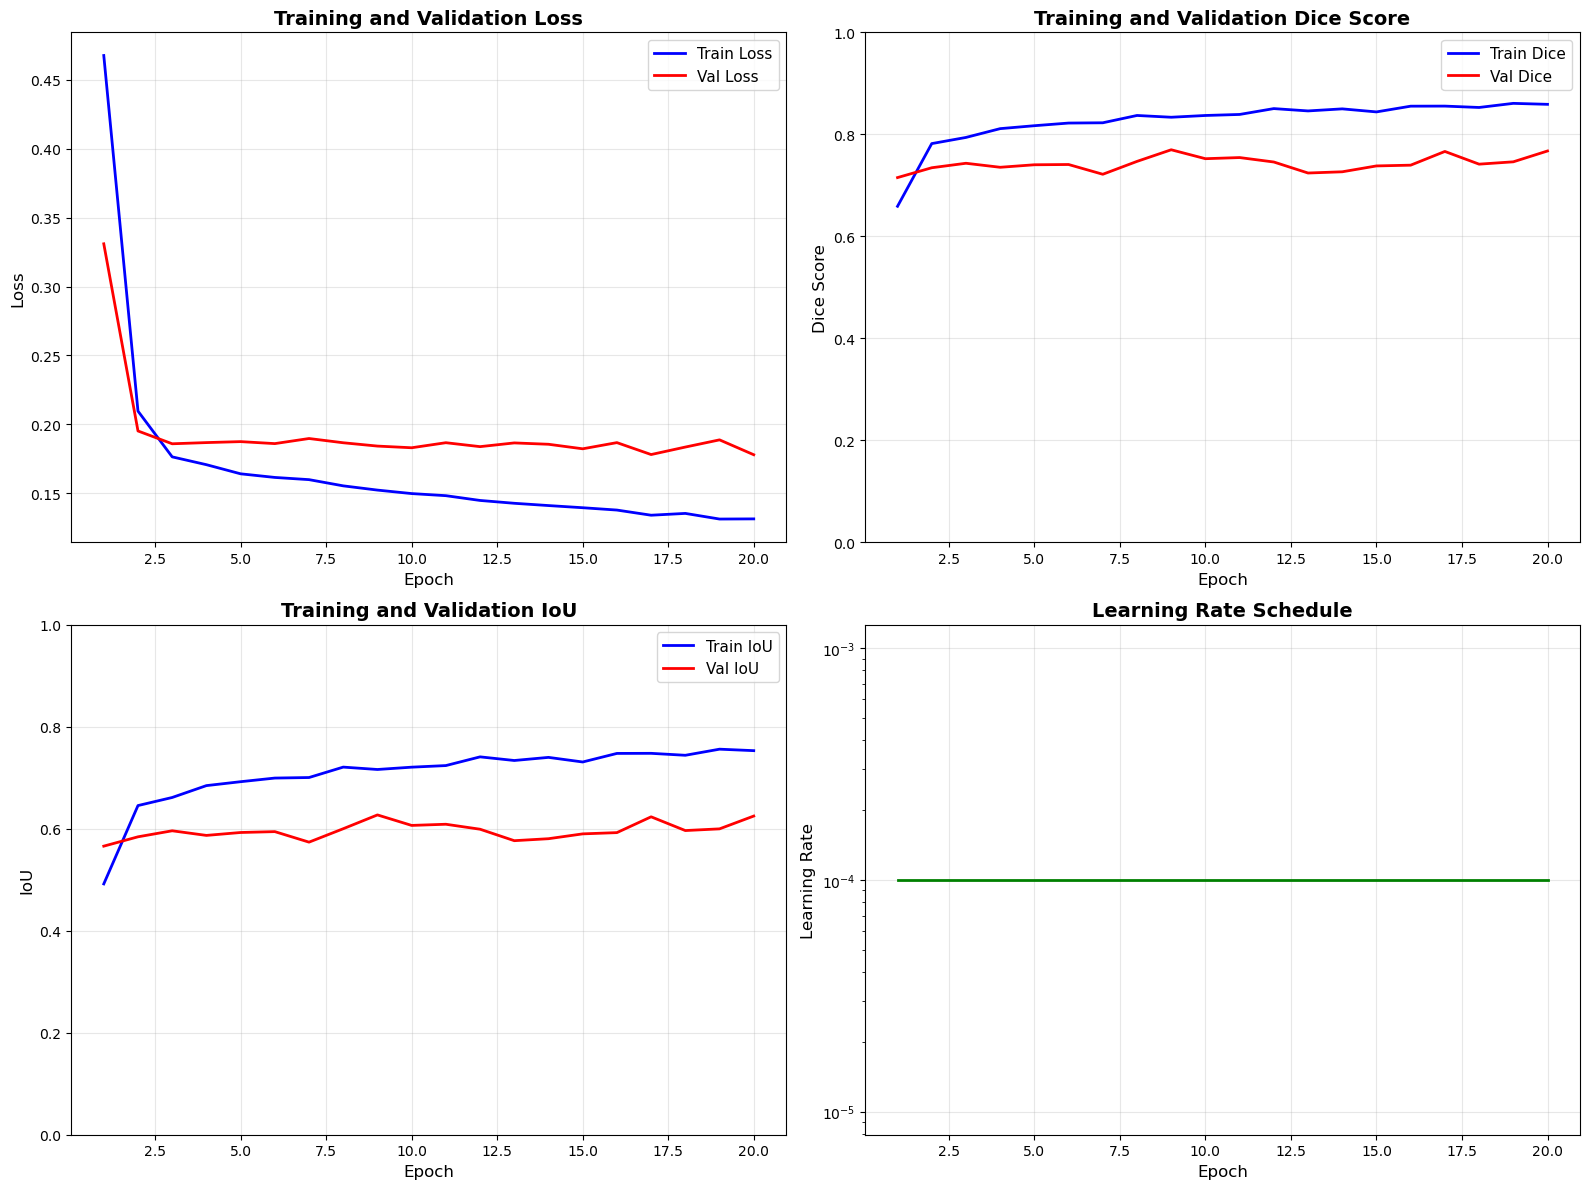


TRAINING SUMMARY
Total epochs:          20
Best validation Dice:  0.7697 (Epoch 9)
Final validation Dice: 0.7673
Best validation loss:  0.1780 (Epoch 20)
Final validation loss: 0.1780
Total training time:   37.00 hours
Avg time per epoch:    110.99 minutes


In [ ]:
# ============================================================================
# VISUALIZE TRAINING HISTORY
# ============================================================================

import json
import matplotlib.pyplot as plt
import numpy as np

# Load training history
with open('checkpoints/training_history.json', 'r') as f:
    history = json.load(f)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs = range(1, len(history['train_loss']) + 1)

# Plot 1: Loss
axes[0, 0].plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Train Loss')
axes[0, 0].plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Val Loss')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Dice Score
axes[0, 1].plot(epochs, history['train_dice'], 'b-', linewidth=2, label='Train Dice')
axes[0, 1].plot(epochs, history['val_dice'], 'r-', linewidth=2, label='Val Dice')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Dice Score', fontsize=12)
axes[0, 1].set_title('Training and Validation Dice Score', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Plot 3: IoU
axes[1, 0].plot(epochs, history['train_iou'], 'b-', linewidth=2, label='Train IoU')
axes[1, 0].plot(epochs, history['val_iou'], 'r-', linewidth=2, label='Val IoU')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('IoU', fontsize=12)
axes[1, 0].set_title('Training and Validation IoU', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Plot 4: Learning Rate
axes[1, 1].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.savefig('checkpoints/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"Total epochs:          {len(epochs)}")
print(f"Best validation Dice:  {max(history['val_dice']):.4f} (Epoch {np.argmax(history['val_dice']) + 1})")
print(f"Final validation Dice: {history['val_dice'][-1]:.4f}")
print(f"Best validation loss:  {min(history['val_loss']):.4f} (Epoch {np.argmin(history['val_loss']) + 1})")
print(f"Final validation loss: {history['val_loss'][-1]:.4f}")
print(f"Total training time:   {sum(history['epoch_times'])/3600:.2f} hours")
print(f"Avg time per epoch:    {np.mean(history['epoch_times'])/60:.2f} minutes")
print("="*80)


In [ ]:
# ============================================================================
# EVALUATE ON TEST SET
# ============================================================================

print("\n" + "="*80)
print("EVALUATING ON TEST SET")
print("="*80)

# Load best model
print("\n📥 Loading best model...")
checkpoint = torch.load('checkpoints/best_model.pth', 
                       map_location=device, 
                       weights_only=False)  # Add this parameter
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded model from epoch {checkpoint['epoch']}")
print(f"   Validation Dice at save: {checkpoint['val_dice']:.4f}")

# Initialize test metrics
test_metrics = SegmentationMetrics(num_classes=4, ignore_background=True, device='cpu')

# Evaluate on test set
print("\n🧪 Running inference on test set...")
test_loss, test_metrics_dict = validate_epoch(
    model=model,
    dataloader=test_loader,
    criterion=criterion,
    device=device,
    metrics=test_metrics
)

# Print detailed test results
print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"\nOverall Metrics:")
print(f"  Test Loss:         {test_loss:.4f}")
print(f"  Mean Dice Score:   {test_metrics_dict['mean_dice']:.4f}")
print(f"  Mean IoU:          {test_metrics_dict['mean_iou']:.4f}")
print(f"  Overall Accuracy:  {test_metrics_dict['overall_accuracy']:.4f}")

print(f"\nPer-Class Metrics:")
print(f"  {'Class':<25} {'Dice':<10} {'IoU':<10} {'Pixel Acc':<10}")
print(f"  {'-'*60}")

class_names = ['Background', 'NCR/NET (Necrotic)', 'Edema', 'Enhancing Tumor']
for i, name in enumerate(class_names):
    dice_val = test_metrics_dict['dice_per_class'][i]
    iou_val = test_metrics_dict['iou_per_class'][i]
    acc_val = test_metrics_dict['pixel_acc_per_class'][i]
    print(f"  {name:<25} {dice_val:<10.4f} {iou_val:<10.4f} {acc_val:<10.4f}")

print("="*80)

# Save test results to file
test_results = {
    'test_loss': test_loss,
    'mean_dice': test_metrics_dict['mean_dice'],
    'mean_iou': test_metrics_dict['mean_iou'],
    'overall_accuracy': test_metrics_dict['overall_accuracy'],
    'per_class_dice': test_metrics_dict['dice_per_class'].tolist(),
    'per_class_iou': test_metrics_dict['iou_per_class'].tolist(),
    'per_class_pixel_acc': test_metrics_dict['pixel_acc_per_class'].tolist()
}

with open('checkpoints/test_results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

print(f"\n✅ Test results saved to 'checkpoints/test_results.json'")



EVALUATING ON TEST SET

📥 Loading best model...
✅ Loaded model from epoch 9
   Validation Dice at save: 0.7697

🧪 Running inference on test set...


Validation: 100%|████████████████████████████████████████████████████| 459/459 [14:38] , loss=0.1948



  Computing metrics...

TEST SET RESULTS

Overall Metrics:
  Test Loss:         0.1948
  Mean Dice Score:   0.7751
  Mean IoU:          0.6376
  Overall Accuracy:  0.9911

Per-Class Metrics:
  Class                     Dice       IoU        Pixel Acc 
  ------------------------------------------------------------
  Background                0.9972     0.9944     0.9981    
  NCR/NET (Necrotic)        0.6929     0.5301     0.5900    
  Edema                     0.7764     0.6345     0.7992    
  Enhancing Tumor           0.8561     0.7483     0.8296    

✅ Test results saved to 'checkpoints/test_results.json'



GENERATING QUALITATIVE RESULTS


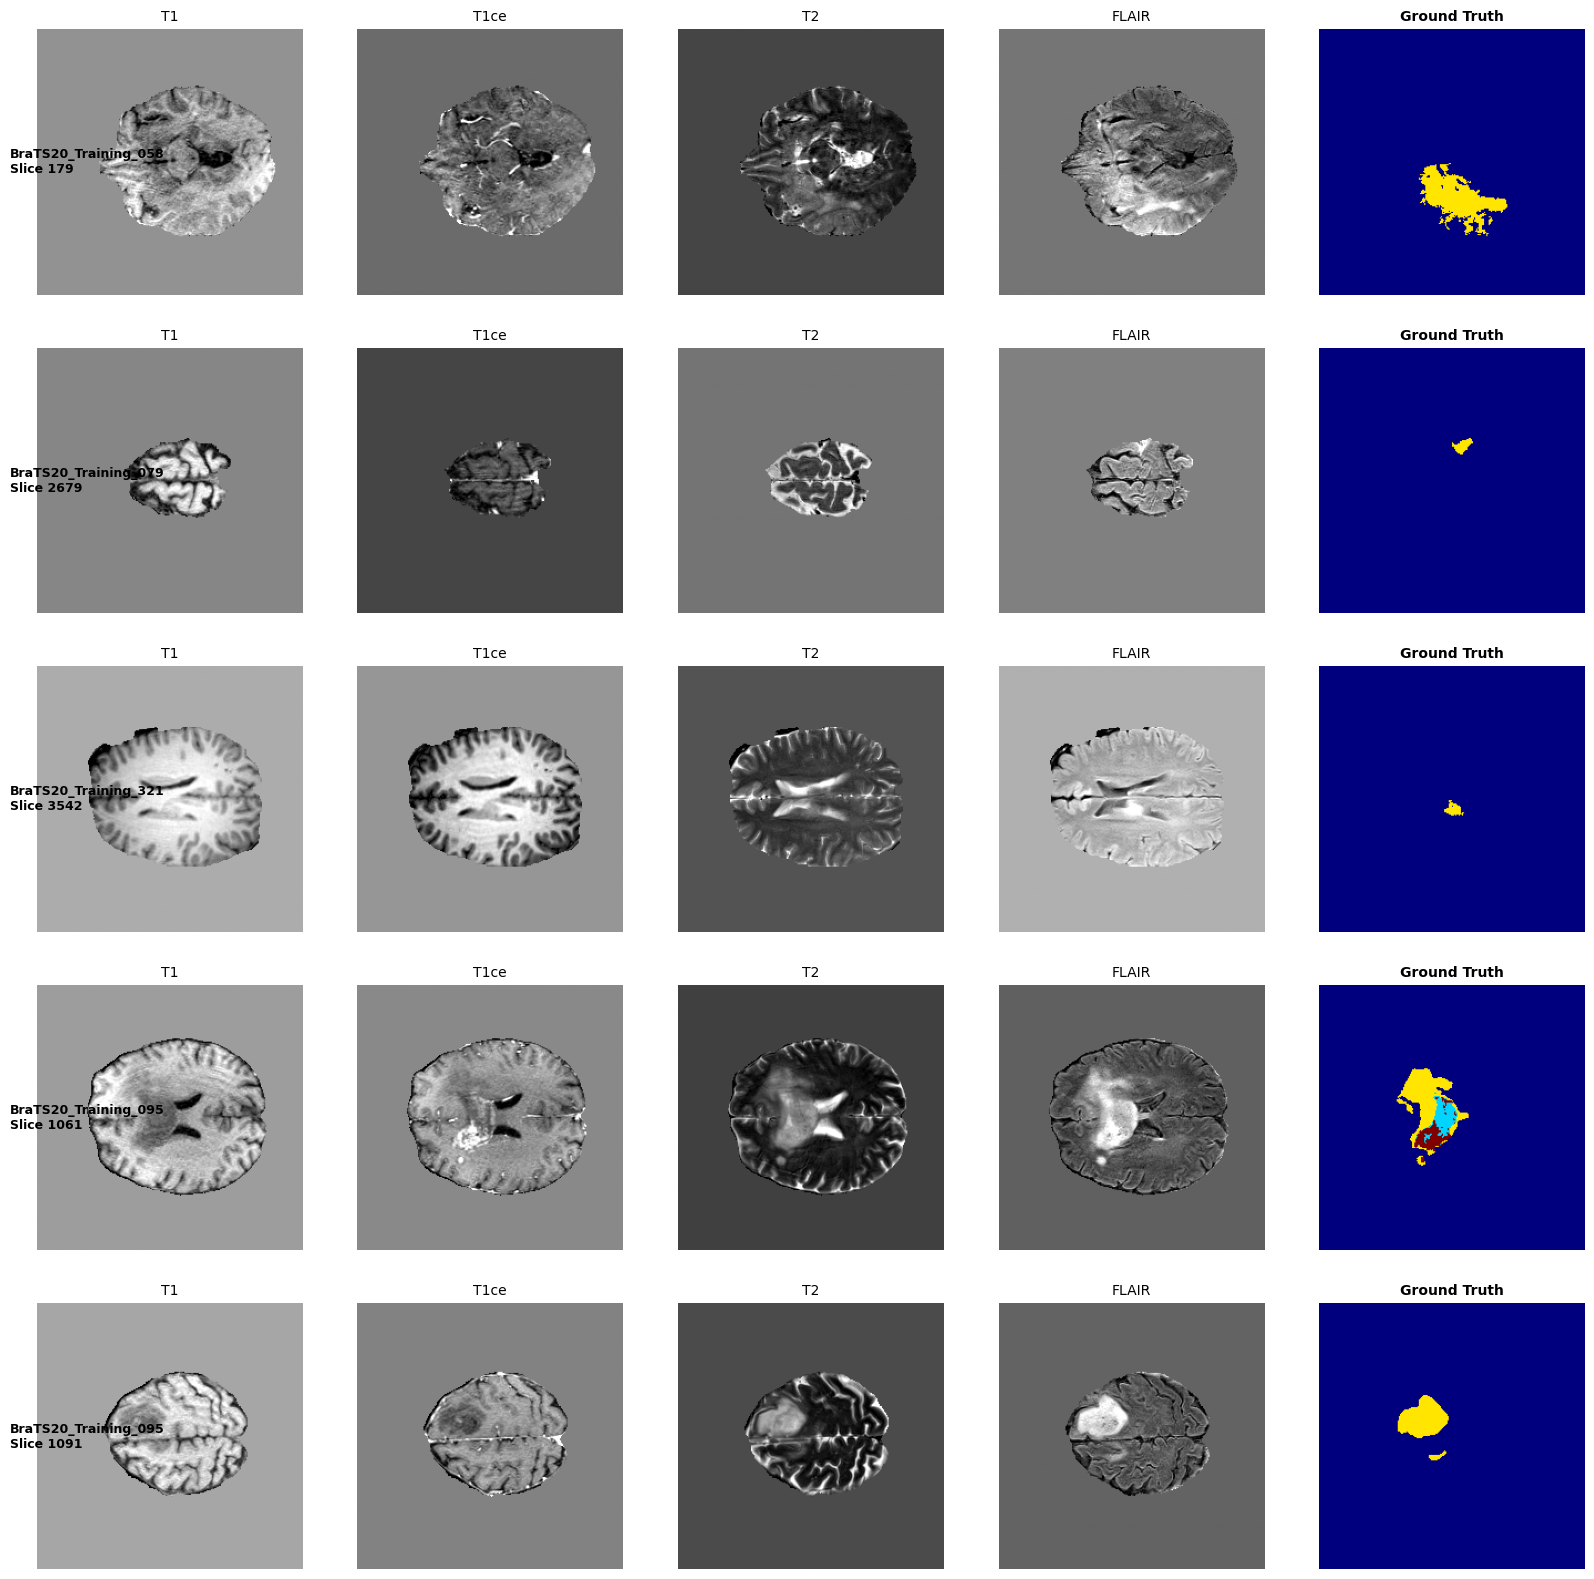

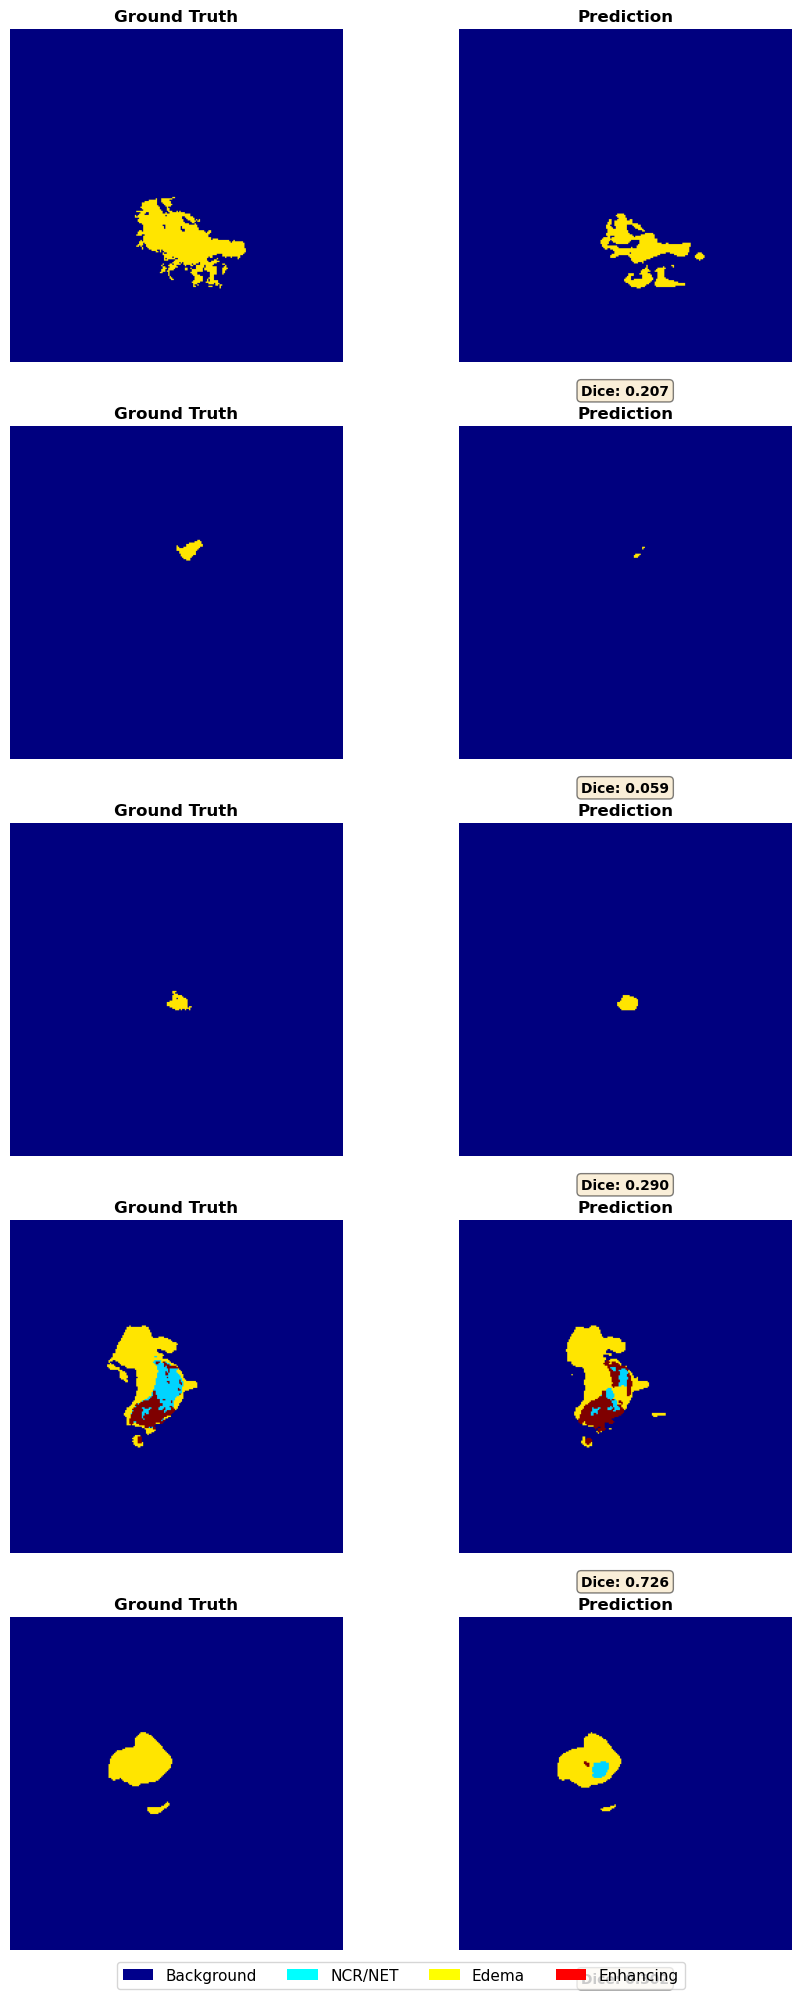


✅ Visualizations saved to:
   - checkpoints/predictions_input.png
   - checkpoints/predictions_comparison.png


In [ ]:
# ============================================================================
# VISUALIZE PREDICTIONS ON TEST SET
# ============================================================================

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def visualize_predictions(model, dataset, device, num_samples=5, save_dir='checkpoints'):
    """
    Visualize model predictions vs ground truth
    """
    model.eval()
    
    # Randomly sample slices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    
    class_names_short = ['Background', 'NCR/NET', 'Edema', 'Enhancing']
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Get data
            image, mask = dataset[idx]
            image_batch = image.unsqueeze(0).to(device)  # Add batch dimension
            
            # Get prediction
            output = model(image_batch)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            
            # Convert tensors to numpy for visualization
            mask_np = mask.cpu().numpy()
            
            # Get patient name for title
            patient_name = dataset.get_patient_name(idx)
            
            # Plot all 4 MRI modalities + ground truth + prediction
            modality_names = ['T1', 'T1ce', 'T2', 'FLAIR']
            
            for j in range(4):
                axes[i, j].imshow(image[j].cpu().numpy(), cmap='gray')
                axes[i, j].set_title(f'{modality_names[j]}', fontsize=10)
                axes[i, j].axis('off')
            
            # Ground truth
            axes[i, 4].imshow(mask_np, cmap='jet', vmin=0, vmax=3)
            axes[i, 4].set_title('Ground Truth', fontsize=10, fontweight='bold')
            axes[i, 4].axis('off')
            
            # Add row label with patient name
            axes[i, 0].text(-0.1, 0.5, f'{patient_name}\nSlice {idx}', 
                           transform=axes[i, 0].transAxes,
                           fontsize=9, verticalalignment='center',
                           rotation=0, fontweight='bold')
    
    # Create a separate figure for predictions
    fig2, axes2 = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask = dataset[idx]
            image_batch = image.unsqueeze(0).to(device)
            
            output = model(image_batch)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            mask_np = mask.cpu().numpy()
            
            # Ground Truth
            axes2[i, 0].imshow(mask_np, cmap='jet', vmin=0, vmax=3)
            axes2[i, 0].set_title('Ground Truth', fontsize=12, fontweight='bold')
            axes2[i, 0].axis('off')
            
            # Prediction
            axes2[i, 1].imshow(pred, cmap='jet', vmin=0, vmax=3)
            axes2[i, 1].set_title('Prediction', fontsize=12, fontweight='bold')
            axes2[i, 1].axis('off')
            
            # Calculate Dice for this slice
            dice_scores = []
            for c in range(1, 4):  # Skip background
                mask_c = (mask_np == c)
                pred_c = (pred == c)
                intersection = np.logical_and(mask_c, pred_c).sum()
                union = mask_c.sum() + pred_c.sum()
                dice = (2. * intersection) / (union + 1e-8)
                dice_scores.append(dice)
            
            avg_dice = np.mean(dice_scores)
            axes2[i, 1].text(0.5, -0.1, f'Dice: {avg_dice:.3f}', 
                            transform=axes2[i, 1].transAxes,
                            fontsize=10, ha='center', fontweight='bold',
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Add legend
    legend_elements = [
        Patch(facecolor='darkblue', label='Background'),
        Patch(facecolor='cyan', label='NCR/NET'),
        Patch(facecolor='yellow', label='Edema'),
        Patch(facecolor='red', label='Enhancing')
    ]
    fig2.legend(handles=legend_elements, loc='upper center', 
               bbox_to_anchor=(0.5, 0.02), ncol=4, fontsize=11)
    
    plt.tight_layout()
    
    # Save figures
    fig.savefig(f'{save_dir}/predictions_input.png', dpi=300, bbox_inches='tight')
    fig2.savefig(f'{save_dir}/predictions_comparison.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"\n✅ Visualizations saved to:")
    print(f"   - {save_dir}/predictions_input.png")
    print(f"   - {save_dir}/predictions_comparison.png")


# Run visualization
print("\n" + "="*80)
print("GENERATING QUALITATIVE RESULTS")
print("="*80)

visualize_predictions(
    model=model,
    dataset=test_dataset,
    device=device,
    num_samples=5,
    save_dir='checkpoints'
)

In [ ]:
# ============================================================================
# GENERATE COMPREHENSIVE RESULTS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("GENERATING RESULTS SUMMARY FOR REPORT")
print("="*80)

# Create summary report
summary = []
summary.append("="*80)
summary.append("BRAIN TUMOR SEGMENTATION - 2D U-NET RESULTS SUMMARY")
summary.append("="*80)
summary.append("")

# Dataset Information
summary.append("DATASET:")
summary.append(f"  Total patients:     {len(patient_folders)}")
summary.append(f"  Train patients:     {len(train_patients)} ({len(train_patients)/len(patient_folders)*100:.1f}%)")
summary.append(f"  Val patients:       {len(val_patients)} ({len(val_patients)/len(patient_folders)*100:.1f}%)")
summary.append(f"  Test patients:      {len(test_patients)} ({len(test_patients)/len(patient_folders)*100:.1f}%)")
summary.append(f"  Train slices:       {len(train_dataset)}")
summary.append(f"  Val slices:         {len(val_dataset)}")
summary.append(f"  Test slices:        {len(test_dataset)}")
summary.append("")

# Model Architecture
total_params, trainable_params = model.count_parameters()
summary.append("MODEL ARCHITECTURE:")
summary.append(f"  Architecture:       2D U-Net")
summary.append(f"  Input channels:     4 (T1, T1ce, T2, FLAIR)")
summary.append(f"  Output classes:     4 (Background, NCR/NET, Edema, Enhancing)")
summary.append(f"  Total parameters:   {total_params:,}")
summary.append(f"  Trainable params:   {trainable_params:,}")
summary.append(f"  Model size:         {total_params * 4 / 1024**2:.2f} MB")
summary.append("")

# Training Configuration
summary.append("TRAINING CONFIGURATION:")
summary.append(f"  Loss function:      Combined (CE: 0.4 + Dice: 0.6)")
summary.append(f"  Optimizer:          Adam (lr={LEARNING_RATE}, wd={WEIGHT_DECAY})")
summary.append(f"  Batch size:         {BATCH_SIZE}")
summary.append(f"  Total epochs:       {len(history['train_loss'])}")
summary.append(f"  Training time:      {sum(history['epoch_times'])/3600:.2f} hours")
summary.append("")

# Training Results
best_epoch = np.argmax(history['val_dice']) + 1
summary.append("TRAINING RESULTS:")
summary.append(f"  Best val Dice:      {max(history['val_dice']):.4f} (Epoch {best_epoch})")
summary.append(f"  Best val IoU:       {max(history['val_iou']):.4f}")
summary.append(f"  Final train loss:   {history['train_loss'][-1]:.4f}")
summary.append(f"  Final val loss:     {history['val_loss'][-1]:.4f}")
summary.append("")

# Test Results
summary.append("TEST SET RESULTS:")
summary.append(f"  Mean Dice:          {test_metrics_dict['mean_dice']:.4f}")
summary.append(f"  Mean IoU:           {test_metrics_dict['mean_iou']:.4f}")
summary.append(f"  Overall Accuracy:   {test_metrics_dict['overall_accuracy']:.4f}")
summary.append("")
summary.append("  Per-Class Test Results:")
summary.append(f"    {'Class':<25} {'Dice':<10} {'IoU':<10}")
summary.append(f"    {'-'*50}")
for i, name in enumerate(class_names):
    summary.append(f"    {name:<25} {test_metrics_dict['dice_per_class'][i]:<10.4f} {test_metrics_dict['iou_per_class'][i]:<10.4f}")
summary.append("")
summary.append("="*80)

# Print to console
summary_text = "\n".join(summary)
print(summary_text)

# Save to file
with open('checkpoints/results_summary.txt', 'w') as f:
    f.write(summary_text)

print(f"\n✅ Results summary saved to 'checkpoints/results_summary.txt'")
print(f"\n📊 All results saved in 'checkpoints/' directory:")
print(f"   - best_model.pth (best model weights)")
print(f"   - training_history.json (training metrics)")
print(f"   - test_results.json (test set metrics)")
print(f"   - results_summary.txt (comprehensive summary)")
print(f"   - training_curves.png (training plots)")
print(f"   - predictions_input.png (sample predictions)")
print(f"   - predictions_comparison.png (GT vs predictions)")



GENERATING RESULTS SUMMARY FOR REPORT
BRAIN TUMOR SEGMENTATION - 2D U-NET RESULTS SUMMARY

DATASET:
  Total patients:     369
  Train patients:     258 (69.9%)
  Val patients:       55 (14.9%)
  Test patients:      56 (15.2%)
  Train slices:       17071
  Val slices:         3681
  Test slices:        3670

MODEL ARCHITECTURE:
  Architecture:       2D U-Net
  Input channels:     4 (T1, T1ce, T2, FLAIR)
  Output classes:     4 (Background, NCR/NET, Edema, Enhancing)
  Total parameters:   31,038,404
  Trainable params:   31,038,404
  Model size:         118.40 MB

TRAINING CONFIGURATION:
  Loss function:      Combined (CE: 0.4 + Dice: 0.6)
  Optimizer:          Adam (lr=0.0001, wd=1e-05)
  Batch size:         8
  Total epochs:       20
  Training time:      37.00 hours

TRAINING RESULTS:
  Best val Dice:      0.7697 (Epoch 9)
  Best val IoU:       0.6272
  Final train loss:   0.1314
  Final val loss:     0.1780

TEST SET RESULTS:
  Mean Dice:          0.7751
  Mean IoU:           0.6376